In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.svm import SVC

2025-08-31 06:36:25.100209: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756622185.282994      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756622185.336695      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_dir = "/kaggle/input/coffee-bean-tanvir/train"
test_dir = "/kaggle/input/coffee-bean-tanvir/test"

# Training Data Generator (with validation split)
# ======================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2   # 20% of training data for validation
)

# Training generator
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'    # <-- this is the training subset
)

# Validation generator
val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset='validation'  # <-- this is the validation subset
)

# ======================
# Test Data Generator (final evaluation)
# ======================
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Quick sanity check
# ======================
print("Train classes mapping:", train_gen.class_indices)
print("Validation classes mapping:", val_gen.class_indices)
print("Test classes mapping:", test_gen.class_indices)

Found 960 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Train classes mapping: {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}
Validation classes mapping: {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}
Test classes mapping: {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}


In [4]:
def se_block(feature_map, ratio=8):
    channel = feature_map.shape[-1]
    
    # Squeeze: Global Average Pooling
    se = layers.GlobalAveragePooling2D()(feature_map)
    se = layers.Reshape((1,1,channel))(se)
    
    # Excitation: Two FC layers
    se = layers.Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)(se)
    se = layers.Dense(channel, activation='sigmoid', kernel_initializer='he_normal', use_bias=True)(se)
    
    # Scale feature map
    x = layers.Multiply()([feature_map, se])
    return x

In [5]:
def build_se_cnn(input_shape=(128,128,3), num_classes=4):
    inputs = Input(shape=input_shape)

    # Conv Block 1
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = se_block(x)

    # Conv Block 2
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = se_block(x)

    # Conv Block 3
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = se_block(x)

    # Global Average Pooling (feature output)
    gap = layers.GlobalAveragePooling2D()(x)

    # Dense head for training only
    dense = layers.Dense(256, activation='relu')(gap)
    dense = layers.Dropout(0.5)(dense)
    outputs = layers.Dense(num_classes, activation='softmax')(dense)

    model = models.Model(inputs, outputs)
    return model

In [6]:
num_classes = train_gen.num_classes
se_model = build_se_cnn(input_shape=(128,128,3), num_classes=num_classes)

se_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = se_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    verbose=1
)

I0000 00:00:1756622198.711906      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1756622205.884770     115 service.cc:148] XLA service 0x7b3220007860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756622205.885593     115 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756622206.488389     115 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/30 ━━━━━━━━━━━━━━━━━━━━ 4:35 9s/step - accuracy: 0.2500 - loss: 1.3861

I0000 00:00:1756622210.323317     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 508ms/step - accuracy: 0.2407 - loss: 1.3882 - val_accuracy: 0.2500 - val_loss: 1.3857
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 292ms/step - accuracy: 0.2596 - loss: 1.3844 - val_accuracy: 0.3167 - val_loss: 1.3509
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 292ms/step - accuracy: 0.4151 - loss: 1.3010 - val_accuracy: 0.5000 - val_loss: 0.9545
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 288ms/step - accuracy: 0.5779 - loss: 0.8382 - val_accuracy: 0.7458 - val_loss: 0.6883
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 290ms/step - accuracy: 0.7124 - loss: 0.6250 - val_accuracy: 0.7375 - val_loss: 0.5955
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 290ms/step - accuracy: 0.7932 - loss: 0.4847 - val_accuracy: 0.8792 - val_loss: 0.3211
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 289ms/step - accuracy: 0.9002 - loss: 0.2664 - val_accuracy: 0.9458 - val_loss: 0.1608
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 289ms/step - accuracy: 0.9180 - loss: 0.1884 - val_accuracy: 0.9625 - val

In [7]:
feature_extractor = models.Model(
    inputs=se_model.input,
    outputs=se_model.layers[-4].output   # GAP output before Dense
)
def extract_features(model, generator):
    features = []
    labels = []
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        feat = model.predict(x_batch, verbose=0)
        features.append(feat)
        labels.append(np.argmax(y_batch, axis=1))
    features = np.vstack(features)
    labels = np.hstack(labels)
    return features, labels
X_train, y_train = extract_features(feature_extractor, train_gen)
X_val, y_val     = extract_features(feature_extractor, val_gen)
X_test, y_test   = extract_features(feature_extractor, test_gen)

In [8]:
# Apply StandardScaler to the extracted features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [9]:
# SVM Classifier
# ======================
svm = SVC(kernel='linear', probability=True, random_state=42) # probability=True is needed for predict_proba
svm.fit(X_train_scaled, y_train)

SVC(kernel='linear', probability=True, random_state=42)

In [13]:
# Evaluate the SVM classifier on validation data
y_val_pred = svm.predict(X_val)
print("Validation Accuracy (SVM):", accuracy_score(y_val, y_val_pred))

# Evaluate the SVM classifier on test data
y_test_pred = svm.predict(X_test)
print("Test Accuracy (SVM):", accuracy_score(y_test, y_test_pred))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred, target_names=list(train_gen.class_indices.keys())))

Validation Accuracy (SVM): 0.25
Test Accuracy (SVM): 0.25
              precision    recall  f1-score   support

        Dark       0.00      0.00      0.00       100
       Green       0.00      0.00      0.00       100
       Light       0.00      0.00      0.00       100
      Medium       0.25      1.00      0.40       100

    accuracy                           0.25       400
   macro avg       0.06      0.25      0.10       400
weighted avg       0.06      0.25      0.10       400



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


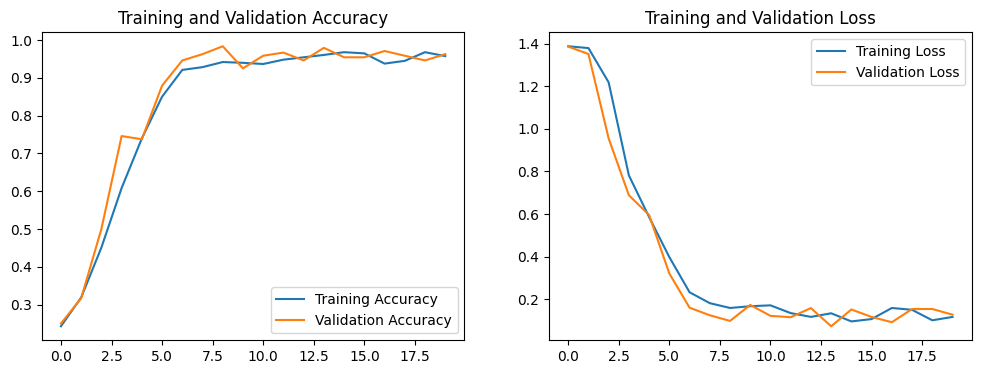

In [11]:
# Plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Accuracy: 0.25
Precision: 0.0625
Recall: 0.25
F1-score: 0.1
Confusion Matrix:
 [[  0   0   0 100]
 [  0   0   0 100]
 [  0   0   0 100]
 [  0   0   0 100]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


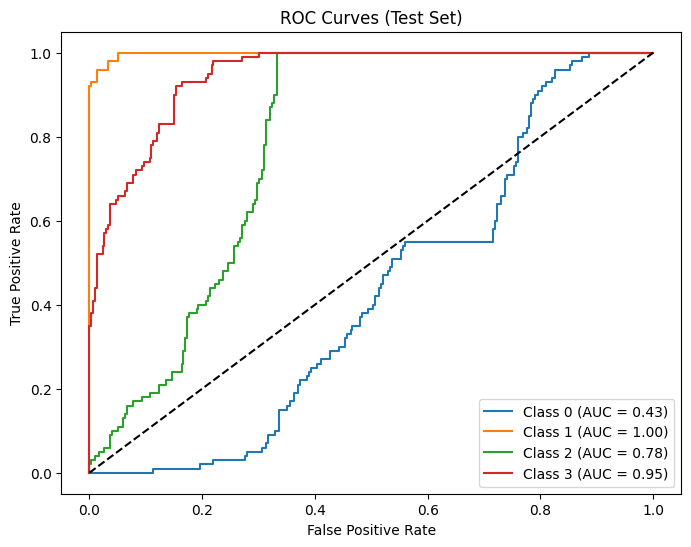

Test AUC: 0.7877583333333333


In [12]:
# ---- Predictions ----
y_test_pred = svm.predict(X_test)
# For probability estimates, use predict_proba
y_test_proba = svm.predict_proba(X_test)


# ---- Basic Metrics ----
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred, average='macro'))
print("Recall:", recall_score(y_test, y_test_pred, average='macro'))
print("F1-score:", f1_score(y_test, y_test_pred, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

# ---- ROC-AUC Curves ----
# Binarize labels for multi-class ROC
classes_present = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes_present)

# Only plot ROC if at least 2 classes are present
if y_test_bin.shape[1] > 1:
    plt.figure(figsize=(8,6))
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
        plt.plot(fpr, tpr, label=f"Class {classes_present[i]} (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Test Set)")
    plt.legend()
    plt.show()

    # Compute overall ROC-AUC
    print("Test AUC:", roc_auc_score(y_test_bin, y_test_proba, multi_class='ovr'))
else:
    print("ROC-AUC skipped: less than 2 classes present in test set")